# Introduction

We will be using the text bodies in https://en.wikipedia.org/wiki/Border_Gateway_Protocol and http://caesar.cs.illinois.edu/papers/policies.pdf to create a singular knowledge graph regarding Border Gateway Policies (BGPs). In order to accomplish this, the work will be split into three major components: data preparation, information extraction and graph creation.

In [1]:
# !pip install ipynb
# !pip install 'decorator == 5.0.7'
import re
import pandas as pd
from ipynb.fs.full.my_functions import split_into_sentences

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib
from matplotlib import pyplot as plt
# import tqdm
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Data Preparation

Of the two documents, one is a PDF and the other a website. We want the data to be clean and readily usable, which means that we will have to convert both documents into a normalized, delimited text file. Preferably a CSV file.

We use the `tika` library to parse data from PDFs and convert them into a dictionary that contains the PDF's metadata, content and status. The content is the string equivalent of the PDF's text. There's still some junk data contained in the content, so I performed a bit of manual cleaning.

In [2]:
# !pip install tika
TIKA_SERVER_JAR="file:////tika-server.jar"

from tika import parser
raw = parser.from_file('policies_clean.pdf')
content = raw['content']

text_file = open("content.txt", "w")
text_file.write(content)
text_file.close()

# print(content)

## Sentence Segmentation

`split_into_sentences()` is a reliable method to split text into sentences by using complex, handwritten regex methods. While effective, it is complicated and would be hard to update for those not proficient with regex. [Source.](https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences)

In [3]:
clean = split_into_sentences(content)
# print(clean)

An amazing sentence segmenting algorithm is NLTK's Punkt Sentence Tokenizer. From `nltk.tokenize` documentation,

>This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target language before it can be used.<br><br>The NLTK data package includes a pre-trained Punkt tokenizer for English. Source.

[Source](https://www.nltk.org/api/nltk.tokenize.html)

In [4]:
import nltk.data
text = '''
Punkt knows that the periods in Mr. Smith and Johann S. Bach do not mark sentence boundaries.
And sometimes sentences can start with non-capitalized words.  
i is a good variable name.
'''
text2 = '''
During this time, it became apparent that vanilla shortest-path routing would be insufficient to handle the myriad operational, economic, and political factors involved in routing. 
ISPs began to modify routing configurations to support routing policies, i.e. goals held by the router’s owner that controlled which routes were chosen and which routes were propagated to neighbors.
'''
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
print('\n-----\n'.join(sent_detector.tokenize(text.strip())))

Punkt knows that the periods in Mr. Smith and Johann S. Bach do not mark sentence boundaries.
-----
And sometimes sentences can start with non-capitalized words.
-----
i is a good variable name.


It works great on many cases!

In [5]:
print('\n-----\n'.join(sent_detector.tokenize(text2.strip())))

During this time, it became apparent that vanilla shortest-path routing would be insufficient to handle the myriad operational, economic, and political factors involved in routing.
-----
ISPs began to modify routing configurations to support routing policies, i.e.
-----
goals held by the router’s owner that controlled which routes were chosen and which routes were propagated to neighbors.


But we still need to train it to catch abbreviations.

In [6]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
punkt_param = PunktParameters()
abbreviation = ['i.e', 'e.g']
punkt_param.abbrev_types = set(abbreviation)

tokenizer = PunktSentenceTokenizer(punkt_param)
tokenizer.train(text2)

In [7]:
tokenizer.tokenize(text2)

['\nDuring this time, it became apparent that vanilla shortest-path routing would be insufficient to handle the myriad operational, economic, and political factors involved in routing.',
 'ISPs began to modify routing configurations to support routing policies, i.e. goals held by the router’s owner that controlled which routes were chosen and which routes were propagated to neighbors.']

Great, now our tokenizer can handle more cases!

In [8]:
clean = tokenizer.tokenize(content)
for i in range(len(clean)):
    clean[i] = clean[i].replace('\n','')
    clean[i] = clean[i].replace('\t','')

In [9]:
d = {'sentences': clean}
df = pd.DataFrame(d) 
    
# saving the dataframe as csv 
df.to_csv('policies.csv') 

In [10]:
candidate_sentences = pd.read_csv('policies.csv')
del candidate_sentences['Unnamed: 0']
candidate_sentences.columns

Index(['sentences'], dtype='object')

In [11]:
candidate_sentences['sentences'].sample(2)

170                                                                                                                                                                          2.
135    However, an ISP may convince its neighbor (perhaps through economic incentives) to allow the ISP to control how much traffic it receives on each link from the neighbor.
Name: sentences, dtype: object

# Entity Extraction/Named Entity Recognition


In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [13]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentences"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 259/259 [00:01<00:00, 134.02it/s]


In [21]:
entity_pairs

[['', ''],
 ['Internet', 'administrative  entities'],
 ['shortest path routing', 'operational  routing'],
 ['routes', 'neighbors'],
 ['BGP', 'substantially path vector complexity'],
 ['they', 'which'],
 ['common  policies', 'BGP'],
 ['that', 'routing policies'],
 ['', ''],
 ['much  it', 'final  destination'],
 ['shortest path routing', 'administrative  entity'],
 ['vested  traffic', 'economic  reasons'],
 ['forward route who', 'routes'],
 ['first  it', ''],
 ['ISPs', 'BGP'],
 ['huge  that', 'unpredictable  ways'],
 ['modifications', 'highly protocol specification'],
 ['Moreover  complexity', 'different security ISPs'],
 ['certain   they', 'new  design'],
 ['decision BGP', 'routes'],
 ['decision rest', 'fairly  time'],
 ['decision that', 'design'],
 ['also measurement what', 'new  BGP'],
 ['hence  it', 'them'],
 ['common network that', 'policies'],
 ['how design they', 'ISP  mechanisms'],
 ['6 control that', 'malicious  attacks'],
 ['We', 'currently BGP policies'],
 ['We', 'next  sectio

In [14]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [15]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentences'])]

100%|██████████| 259/259 [00:02<00:00, 128.77it/s]


In [16]:
pd.Series(relations).value_counts()[:50]

is                     25
are                    12
done by                 9
wish                    7
suppose                 3
need                    3
do                      3
applied                 3
used by                 3
was                     3
2                       3
allows                  3
3                       2
avoid                   2
protect                 2
have                    2
used for                2
modify                  2
advertising             2
set                     2
be                      2
used                    2
configure               2
want                    2
gives                   2
implements              2
simplifies              2
shows                   2
trigger                 2
generated by            2
began                   2
request                 2
eliminates certain      1
introduced              1
Introduction            1
describe several        1
established between     1
is essential            1
flap        

# Creating the Graph

In [17]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [18]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

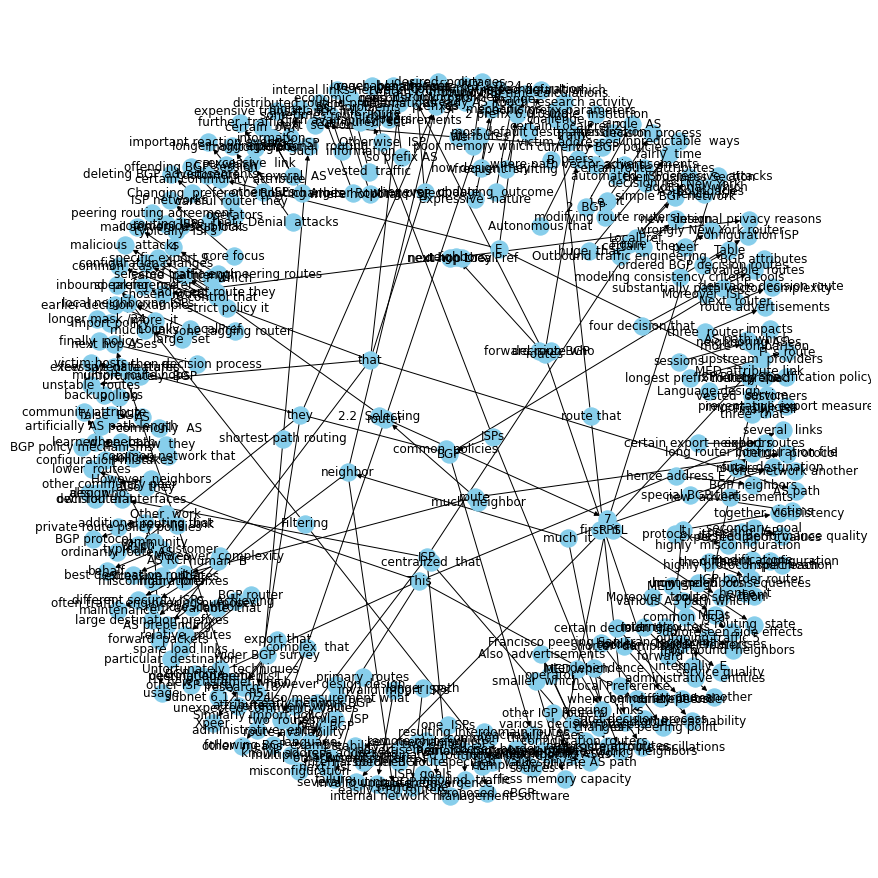

In [19]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

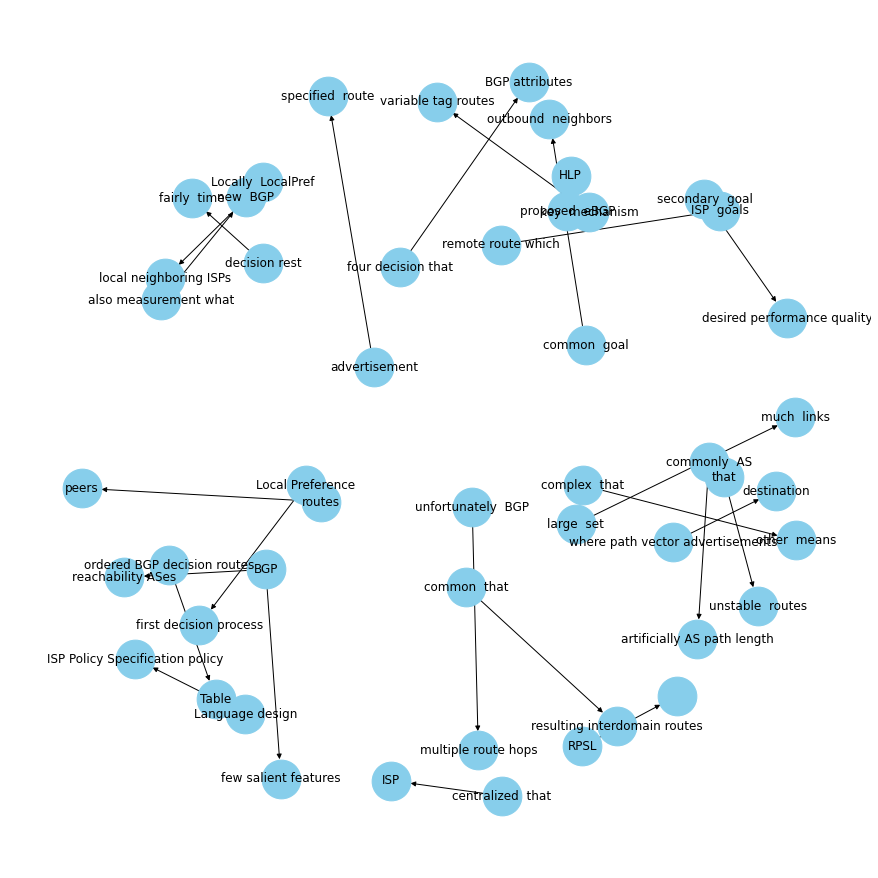

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()